# 281 Final Project

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import urllib
import os

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [12]:
test_path = './seg_test/seg_test/'
train_path = './seg_train/seg_train/'

In [13]:
def dataframe_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    building_path = 'buildings/'
    forest_path = 'forest/'
    glacier_path = 'glacier/'
    mountain_path = 'mountain/'
    sea_path = 'sea/'
    street_path = 'street/'
    
    building_path = os.path.join(filepath, building_path)
    forest_path = os.path.join(filepath, forest_path)
    glacier_path = os.path.join(filepath, glacier_path)
    mountain_path = os.path.join(filepath, mountain_path)
    sea_path = os.path.join(filepath, sea_path)
    street_path = os.path.join(filepath, street_path)

    building_files = [os.path.join(building_path, file) for file in os.listdir(building_path)]
    building_list = ['building'] * len(building_files)
    forest_files = [os.path.join(forest_path, file) for file in os.listdir(forest_path)]
    forest_list = ['forest'] * len(forest_files)
    glacier_files = [os.path.join(glacier_path, file) for file in os.listdir(glacier_path)]
    glacier_list = ['glacier'] * len(glacier_files)
    mountain_files = [os.path.join(mountain_path, file) for file in os.listdir(mountain_path)]
    mountain_list = ['mountain'] * len(mountain_files)
    sea_files = [os.path.join(sea_path, file) for file in os.listdir(sea_path)]
    sea_list = ['sea'] * len(sea_files)
    street_files = [os.path.join(street_path, file) for file in os.listdir(street_path)]
    street_list = ['street'] * len(street_files)

    paths = building_files + forest_files + glacier_files + mountain_files + sea_files + street_files
    labels = building_list + forest_list + glacier_list + mountain_list + sea_list + street_list

    df = pd.DataFrame({'files': paths, 'labels': labels})

    return df

In [14]:
#Create dataframe and split train/validation
df = dataframe_img(train_path)

# Define the percentage of data to assign to the validation set
validation_split = 0.2

# Create an empty 'train_or_val' column
df['train_or_val'] = 'training'

# Group the data by 'labels'
groups = df.groupby('labels')

# Update 10% of rows for each label to 'validation'
for name, group in groups:
    num_validation_samples = int(len(group) * validation_split)
    validation_indices = np.random.choice(group.index, num_validation_samples, replace=False)
    df.loc[validation_indices, 'train_or_val'] = 'validation'
    

In [15]:
df_train = df[df['train_or_val']=='training'].reset_index().drop('index', axis=1)
df_val = df[df['train_or_val']=='validation'].reset_index().drop('index', axis=1)
df_test =  dataframe_img(test_path)

In [16]:
df_train.to_csv('train_data_no_features.csv')
df_val.to_csv('val_data_no_features.csv')
df_test.to_csv('test_data_no_features.csv')

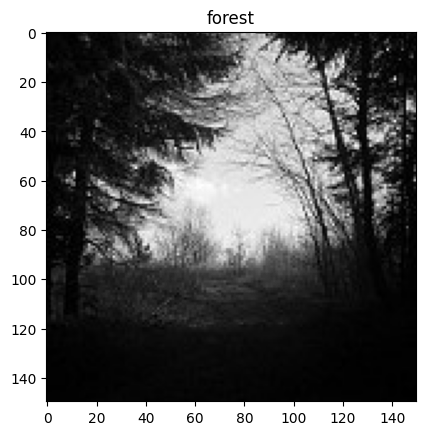

(150, 150)

In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from a file
img = read_image(df_train['files'][2000])
# Get the label for the image
label = df_train['labels'][2000]
# Display the image
plt.imshow(img, cmap='gray')  # 'cmap' specifies the colormap for grayscale
plt.title(label)  # Set the title to the label
plt.show()

img.shape

In [18]:
import cv2

In [20]:
objects = []
for filepath in df_train['files']:
    image = cv2.imread(filepath) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    edges = cv2.Canny(blur, 50, 150)
    dilated = cv2.dilate(edges, (1, 1), iterations=0) 
    (cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # plt.imshow(blur, cmap='gray')
    objects.append(len(cnt))
    # print(f"This image has {len(cnt)} objects")
    # plt.imshow(dilated, cmap='gray')
    # plt.show()

In [21]:
df_train['object count'] = objects
df_train.to_csv('train_with_features.csv')

In [22]:
objects = []
for filepath in df_val['files']:
    image = cv2.imread(filepath) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    edges = cv2.Canny(blur, 50, 150)
    dilated = cv2.dilate(edges, (1, 1), iterations=0) 
    (cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # plt.imshow(blur, cmap='gray')
    objects.append(len(cnt))

df_val['object count'] = objects
df_val.to_csv('val_with_features.csv')

In [23]:
objects = []
for filepath in df_test['files']:
    image = cv2.imread(filepath) 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (11, 11), 0)
    edges = cv2.Canny(blur, 50, 150)
    dilated = cv2.dilate(edges, (1, 1), iterations=0) 
    (cnt, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # plt.imshow(blur, cmap='gray')
    objects.append(len(cnt))

df_test['object count'] = objects
df_test.to_csv('test_with_features.csv')

In [24]:
# lets create a histogram of object counts by image type to see if there's a pattern
train_w_features = pd.read_csv("train_with_features.csv")
train_w_features.head()

,Unnamed: 0,files,labels,train_or_val,object count
0,0,./seg_train/seg_train/buildings/0.jpg,building,training,10
1,1,./seg_train/seg_train/buildings/1001.jpg,building,training,11
2,2,./seg_train/seg_train/buildings/10014.jpg,building,training,34
3,3,./seg_train/seg_train/buildings/10018.jpg,building,training,46
4,4,./seg_train/seg_train/buildings/10056.jpg,building,training,30


In [29]:
labels = train_w_features['labels'].unique()
object_counts_by_label = {}
for label in labels:
    object_counts_by_label[label] = []
    for object_count in train_w_features[train_w_features['labels'] == label]['object count']:
        object_counts_by_label[label].append(object_count)    

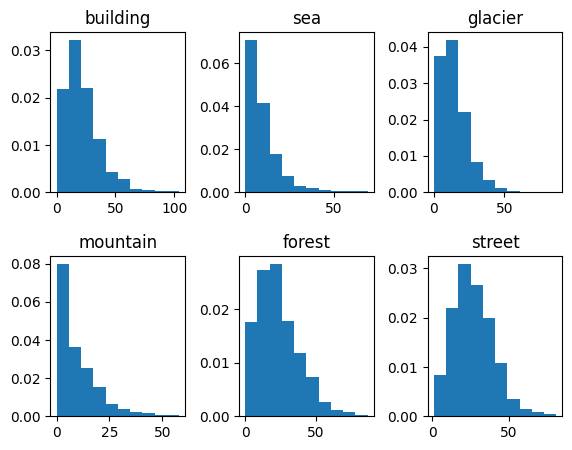

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3)
index = 0
ax_x = [0, 1, 2, 0, 1, 2]
ax_y = [0, 1, 0, 1, 0, 1]

for label, object_counts in object_counts_by_label.items():
    ax[ax_y[index], ax_x[index]].hist(object_counts, density=True)
    ax[ax_y[index], ax_x[index]].set_title(label)
    index += 1
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
# plt.show()
plt.savefig("object)